In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import json
import pandas as pd

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Dense, Dropout,
    BatchNormalization, Concatenate, GlobalMaxPooling1D,
    GlobalAveragePooling1D, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import ast

In [ ]:
# Load preprocessed datasets
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_train_processed.csv')

test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_test_processed.csv')

print("✅ Data loaded successfully!")
print(f"Training shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

✅ Data loaded successfully!
Training shape: (10003, 11)
Test shape: (3080, 11)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Dense, Dropout,
    BatchNormalization, Concatenate, GlobalMaxPooling1D,
    GlobalAveragePooling1D, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import ast

In [ ]:
# Load preprocessed datasets
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_train_processed.csv')

test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_test_processed.csv')

print("✅ Data loaded successfully!")
print(f"Training shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

✅ Data loaded successfully!
Training shape: (10003, 11)
Test shape: (3080, 11)


In [ ]:
# Load tokenizer
with open('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [ ]:
# Convert tokenized sequences back to arrays
train_sequences = np.array([ast.literal_eval(seq) for seq in train_data['tokenized_sequences']])
test_sequences = np.array([ast.literal_eval(seq) for seq in test_data['tokenized_sequences']])

print(f"Training sequences shape: {train_sequences.shape}")
print(f"Test sequences shape: {test_sequences.shape}")

Training sequences shape: (10003, 14)
Test sequences shape: (3080, 14)


In [ ]:
# Prepare labels for multi-task learning
def prepare_labels(data):
    """Prepare labels for hierarchical multi-task learning"""

    # Category labels (Level 1: 4 classes)
    category_encoder = LabelEncoder()
    category_labels = category_encoder.fit_transform(data['category'])

    # Intent labels (Level 2: 77 classes)
    intent_encoder = LabelEncoder()
    intent_labels = intent_encoder.fit_transform(data['label_text'])

    # Urgency labels (Level 3: 3 classes)
    urgency_encoder = LabelEncoder()
    urgency_labels = urgency_encoder.fit_transform(data['urgency'])

    return {
        'category': category_labels,
        'intent': intent_labels,
        'urgency': urgency_labels
    }, {
        'category_encoder': category_encoder,
        'intent_encoder': intent_encoder,
        'urgency_encoder': urgency_encoder
    }


In [ ]:
# Prepare training labels
train_labels, label_encoders = prepare_labels(train_data)
test_labels, _ = prepare_labels(test_data)

print(f"Category classes: {len(label_encoders['category_encoder'].classes_)}")
print(f"Intent classes: {len(label_encoders['intent_encoder'].classes_)}")
print(f"Urgency classes: {len(label_encoders['urgency_encoder'].classes_)}")

Category classes: 4
Intent classes: 77
Urgency classes: 3


In [ ]:
# Create train/validation split from training data
X_train, X_val, y_train_cat, y_val_cat = train_test_split(
    train_sequences, train_labels['category'],
    test_size=0.2, random_state=42, stratify=train_labels['category']
)

_, _, y_train_intent, y_val_intent = train_test_split(
    train_sequences, train_labels['intent'],
    test_size=0.2, random_state=42, stratify=train_labels['category']
)

_, _, y_train_urgency, y_val_urgency = train_test_split(
    train_sequences, train_labels['urgency'],
    test_size=0.2, random_state=42, stratify=train_labels['category']
)

In [ ]:
# Organize training and validation data
train_targets = {
    'category_output': y_train_cat,
    'intent_output': y_train_intent,
    'urgency_output': y_train_urgency
}

val_targets = {
    'category_output': y_val_cat,
    'intent_output': y_val_intent,
    'urgency_output': y_val_urgency
}

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")


Training set: 8002 samples
Validation set: 2001 samples


In [ ]:
 #Display category distribution
print(f"\nCategory distribution:")
for i, category in enumerate(label_encoders['category_encoder'].classes_):
    count = np.sum(train_labels['category'] == i)
    print(f"  {category}: {count} samples")


Category distribution:
  Account Management: 1140 samples
  Card Services: 4416 samples
  General Support: 573 samples
  Transfer & Payments: 3874 samples


In [ ]:
import numpy as np
import random
import tensorflow as tf


# Set random seeds for reproducibility

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#==========Defining the Hierarchical 3-Headed Multi-Task Neural Network model==========


class Hierarchical3HeadedBankingModel:
    """Hierarchical 3-Headed Multi-Task Neural Network for Banking Automation"""

    def __init__(self, vocab_size, max_length, embedding_dim=128):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        self.model = None

    def build_model(self):
        """Build the complete 3-headed hierarchical architecture"""

        print("🏗️ Building 3-Headed Hierarchical Architecture...")

        # Input layer
        input_text = Input(shape=(self.max_length,), name='text_input')

        # Shared embedding layer
        embedding = Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            input_length=self.max_length,
            mask_zero=True,
            name='shared_embedding'
        )(input_text)

        # Shared feature extraction layers
        print("   🔧 Building shared LSTM layers...")
        lstm1 = Bidirectional(
            LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
            name='shared_lstm1'
        )(embedding)

        lstm2 = Bidirectional(
            LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
            name='shared_lstm2'
        )(lstm1)

        # Global pooling for feature aggregation # concatenating both max & Ave vectors improves performance because some tasks rely on strong keywords, others on overall context.
        global_max = GlobalMaxPooling1D(name='global_max')(lstm2)
        global_avg = GlobalAveragePooling1D(name='global_avg')(lstm2)

        # Combine pooled features
        shared_features = Concatenate(name='shared_features')([global_max, global_avg])
        shared_features = BatchNormalization(name='shared_batch_norm')(shared_features)
        shared_features = Dropout(0.5, name='shared_dropout')(shared_features)

        # Dense feature representation
        shared_dense = Dense(256, activation='relu', name='shared_dense')(shared_features)
        shared_dense = BatchNormalization(name='shared_dense_bn')(shared_dense)
        shared_dense = Dropout(0.4, name='shared_dense_dropout')(shared_dense)

        # ============= HEAD 1: CATEGORY CLASSIFICATION =============
        print("   📊 Head 1: Category Classification")
        category_branch = Dense(128, activation='relu', name='category_branch')(shared_dense)
        category_branch = BatchNormalization(name='category_bn')(category_branch)
        category_branch = Dropout(0.3, name='category_dropout')(category_branch)
        category_features = Dense(64, activation='relu', name='category_features')(category_branch)
        category_output = Dense(4, activation='softmax', name='category_output')(category_features)

        # ============= HEAD 2: SPECIALIZED INTENT BRANCHES =============
        print("   🎯 Head 2: Specialized Intent Classification")

        # Card Branch (for card-related intents)
        card_branch = Dense(128, activation='relu', name='card_branch')(shared_dense)
        card_branch = BatchNormalization(name='card_bn')(card_branch)
        card_branch = Dropout(0.3, name='card_dropout')(card_branch)
        card_features = Dense(64, activation='relu', name='card_features')(card_branch)

        # Account Branch (for account-related intents)
        account_branch = Dense(128, activation='relu', name='account_branch')(shared_dense)
        account_branch = BatchNormalization(name='account_bn')(account_branch)
        account_branch = Dropout(0.3, name='account_dropout')(account_branch)
        account_features = Dense(64, activation='relu', name='account_features')(account_branch)

        # Transfer Branch (for transfer-related intents)
        transfer_branch = Dense(128, activation='relu', name='transfer_branch')(shared_dense)
        transfer_branch = BatchNormalization(name='transfer_bn')(transfer_branch)
        transfer_branch = Dropout(0.3, name='transfer_dropout')(transfer_branch)
        transfer_features = Dense(64, activation='relu', name='transfer_features')(transfer_branch)

        # Support Branch (for general support intents)
        support_branch = Dense(128, activation='relu', name='support_branch')(shared_dense)
        support_branch = BatchNormalization(name='support_bn')(support_branch)
        support_branch = Dropout(0.3, name='support_dropout')(support_branch)
        support_features = Dense(64, activation='relu', name='support_features')(support_branch)

        # Combine specialized branches with hierarchical context
        hierarchical_context = Concatenate(name='hierarchical_context')([
            shared_dense, category_features  # Include category context
        ])

        # Combine all specialized features
        combined_intent_features = Concatenate(name='combined_intent_features')([
            card_features, account_features, transfer_features, support_features
        ])

        # Merge for intent prediction
        intent_context = Concatenate(name='intent_context')([
            hierarchical_context, combined_intent_features
        ])

        # Intent classification layers
        intent_dense = Dense(256, activation='relu', name='intent_dense')(intent_context)
        intent_dense = BatchNormalization(name='intent_bn')(intent_dense)
        intent_dense = Dropout(0.3, name='intent_dropout')(intent_dense)

        intent_final = Dense(128, activation='relu', name='intent_final')(intent_dense)
        intent_output = Dense(77, activation='softmax', name='intent_output')(intent_final)

        # ============= HEAD 3: URGENCY CLASSIFICATION =============
        print("   ⚡ Head 3: Urgency Classification with Hierarchical Context")

        # Use hierarchical context (shared + category + intent information)
        urgency_context = Concatenate(name='urgency_context')([
            shared_dense, category_features, intent_dense  # Use all hierarchical info
        ])

        urgency_branch = Dense(128, activation='relu', name='urgency_branch')(urgency_context)
        urgency_branch = BatchNormalization(name='urgency_bn')(urgency_branch)
        urgency_branch = Dropout(0.3, name='urgency_dropout')(urgency_branch)

        urgency_features = Dense(64, activation='relu', name='urgency_features')(urgency_branch)
        urgency_output = Dense(3, activation='softmax', name='urgency_output')(urgency_features)

        # ============= CREATE 3-HEADED MODEL =============
        self.model = Model(
            inputs=input_text,
            outputs=[category_output, intent_output, urgency_output],
            name='Hierarchical3HeadedBankingModel'
        )

        print("✅ Complete 3-Headed Hierarchical Architecture Built!")
        return self.model

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import time
import pandas as pd
import matplotlib.pyplot as plt


print("OPTIMIZER COMPARISON STUDY")
print("Testing: Adam, SGD, RMSprop")


# Store results
optimizer_results = {}

OPTIMIZER COMPARISON STUDY
Testing: Adam, SGD, RMSprop


In [ ]:
# Model parameters
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
max_length = train_sequences.shape[1]

print(f"\nModel Parameters:")
print(f" Vocabulary size: {vocab_size}")
print(f" Max sequence length: {max_length}")
print(f" Embedding dimension: 128")


Model Parameters:
 Vocabulary size: 2297
 Max sequence length: 14
 Embedding dimension: 128


Model Training using Adam Optimizer

In [ ]:
#Training using Adam optimizer

print("\n🔴 TESTING ADAM OPTIMIZER")
print("-" * 50)

# Creating a fresh model (creates a new instance of your custom class,each optimizer sees the same random initialization,Adam’s progress won’t help or hurt other optimizers)
banking_model_adam = Hierarchical3HeadedBankingModel(
    vocab_size=vocab_size,
    max_length=max_length,
    embedding_dim=128
)

model_adam = banking_model_adam.build_model()

# Compile with Adam
model_adam.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'intent_output': 'sparse_categorical_crossentropy',
        'urgency_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={'category_output': 1.0, 'intent_output': 2.0, 'urgency_output': 1.5},
    metrics={'category_output': ['accuracy'], 'intent_output': ['accuracy'], 'urgency_output': ['accuracy']}
)

print(f"✅ Adam model compiled with {model_adam.count_params():,} parameters")


# Define callbacks
callbacks_adam = [
    EarlyStopping(
        monitor='val_intent_output_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'adam_best_model.keras',
        monitor='val_intent_output_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_intent_output_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-8,
        verbose=1,
        mode='max'
    )
]

# Train Adam model
print(" Training with Adam...")
start_time = time.time()

history_adam = model_adam.fit(
    X_train, train_targets,
    validation_data=(X_val, val_targets),
    epochs=30,
    batch_size=32,
    callbacks=callbacks_adam,
    verbose=1
)

adam_time = time.time() - start_time

# Evaluate Adam
print(" Evaluating Adam model...")
adam_results = model_adam.evaluate(X_val, val_targets, verbose=0)
adam_best_acc = max(history_adam.history['val_intent_output_accuracy'])
adam_best_epoch = history_adam.history['val_intent_output_accuracy'].index(adam_best_acc) + 1

optimizer_results['Adam'] = {
    'best_intent_accuracy': adam_best_acc,
    'final_intent_accuracy': adam_results[5],
    'final_category_accuracy': adam_results[4],
    'final_urgency_accuracy': adam_results[6],
    'training_time': adam_time,
    'epochs_trained': len(history_adam.history['loss']),
    'best_epoch': adam_best_epoch,
    'history': history_adam.history
}

print(f" ADAM RESULTS:")
print(f"   Best Intent Accuracy: {adam_best_acc:.4f} (epoch {adam_best_epoch})")
print(f"   Final Intent Accuracy: {adam_results[5]:.4f}")
print(f"   Training Time: {adam_time:.2f} seconds")

# Save Adam model
model_adam.save('best_model_adam.keras')
print(" Adam model saved")



🔴 TESTING ADAM OPTIMIZER
--------------------------------------------------
🏗️ Building 3-Headed Hierarchical Architecture...
   🔧 Building shared LSTM layers...
   📊 Head 1: Category Classification
   🎯 Head 2: Specialized Intent Classification
   ⚡ Head 3: Urgency Classification with Hierarchical Context
✅ Complete 3-Headed Hierarchical Architecture Built!
✅ Adam model compiled with 1,272,340 parameters
 Training with Adam...
Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - category_output_accuracy: 0.4753 - category_output_loss: 1.2963 - intent_output_accuracy: 0.0314 - intent_output_loss: 4.4619 - loss: 12.0007 - urgency_output_accuracy: 0.4899 - urgency_output_loss: 1.1871
Epoch 1: val_intent_output_accuracy improved from -inf to 0.01199, saving model to adam_best_model.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 74s 177ms/step - category_output_accuracy: 0.4758 - category_output_loss: 1.2952 - intent_output_accuracy: 0.0315 - intent_output_loss: 4.4603 - loss: 11.9958 - urgency_ou

In [ ]:
print(f" ADAM RESULTS:")
print(f"   Best Intent Accuracy: {adam_best_acc:.4f} (epoch {adam_best_epoch})")
print(f"   Final Intent Accuracy: {adam_results[5]:.4f}")
print(f"   Final Category Accuracy: {adam_results[4]:.4f}")
print(f"   Final Urgency Accuracy: {adam_results[6]:.4f}")
print(f"   Training Time: {adam_time:.2f} seconds")

 ADAM RESULTS:
   Best Intent Accuracy: 0.8376 (epoch 30)
   Final Intent Accuracy: 0.8376
   Final Category Accuracy: 0.9425
   Final Urgency Accuracy: 0.7616
   Training Time: 1880.49 seconds


In [ ]:
# Final loss for each head (in last epoch)
final_loss_category = history_adam.history['category_output_loss'][-1]
final_loss_intent   = history_adam.history['intent_output_loss'][-1]
final_loss_urgency  = history_adam.history['urgency_output_loss'][-1]

# Overall loss
final_loss_total = history_adam.history['loss'][-1]

print(f"Final Loss - Total: {final_loss_total:.4f}, Category: {final_loss_category:.4f}, Intent: {final_loss_intent:.4f}, Urgency: {final_loss_urgency:.4f}")


Final Loss - Total: 1.2621, Category: 0.0998, Intent: 0.2592, Urgency: 0.4306


In [ ]:
# Minimum loss for each head
min_loss_category = min(history_adam.history['category_output_loss'])
min_loss_intent   = min(history_adam.history['intent_output_loss'])
min_loss_urgency  = min(history_adam.history['urgency_output_loss'])

# Overall minimum loss
min_loss_total = min(history_adam.history['loss'])

print(f"Minimum Loss - Total: {min_loss_total:.4f}, Category: {min_loss_category:.4f}, Intent: {min_loss_intent:.4f}, Urgency: {min_loss_urgency:.4f}")

Minimum Loss - Total: 1.2621, Category: 0.0963, Intent: 0.2592, Urgency: 0.4306


In [ ]:
# Update Adam results dictionary
optimizer_results['Adam'].update({
    'final_loss_total': final_loss_total,
    'final_loss_category': final_loss_category,
    'final_loss_intent': final_loss_intent,
    'final_loss_urgency': final_loss_urgency,
    'min_loss_total': min_loss_total,
    'min_loss_category': min_loss_category,
    'min_loss_intent': min_loss_intent,
    'min_loss_urgency': min_loss_urgency
})

print("Optimizer_results dictionary is updated with loss values")

Optimizer_results dictionary is updated with loss values


In [ ]:
# ============= SAVE ADAM TRAINED MODEL AND COMPONENTS =============
print(f"\n💾 SAVING ADAM MODEL AND COMPONENTS")
print("-" * 50)

# Define Google Drive save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/'
os.makedirs(save_dir, exist_ok=True)

# 1️⃣ Save the trained Adam model
adam_model_path = f'{save_dir}hierarchical_banking_model_adam.keras'
model_adam.save(adam_model_path)
print(f"✅ Model saved: {adam_model_path}")

# 2️⃣ Save label encoders
adam_encoders_path = f'{save_dir}label_encoders_adam.pkl'
with open(adam_encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"✅ Label encoders saved: {adam_encoders_path}")

# 3️⃣ Save model parameters & metadata
adam_info = {
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'vocab_size': vocab_size,
    'max_length': max_length,
    'embedding_dim': 128,
    'num_categories': len(label_encoders['category_encoder'].classes_),
    'num_intents': len(label_encoders['intent_encoder'].classes_),
    'num_urgency_levels': len(label_encoders['urgency_encoder'].classes_),
    'total_parameters': model_adam.count_params(),
    'training_epochs': len(history_adam.history['loss']),
    'best_val_category_accuracy': max(history_adam.history['val_category_output_accuracy']),
    'best_val_intent_accuracy': max(history_adam.history['val_intent_output_accuracy']),
    'best_val_urgency_accuracy': max(history_adam.history['val_urgency_output_accuracy']),
    'training_time_sec': adam_time,
    'best_epoch': adam_best_epoch
}

adam_info_path = f'{save_dir}model_info_adam.json'
with open(adam_info_path, 'w') as f:
    json.dump(adam_info, f, indent=2)
print(f"✅ Model info saved: {adam_info_path}")

# 4️⃣ Save training history
adam_history_path = f'{save_dir}training_history_adam.csv'
pd.DataFrame(history_adam.history).to_csv(adam_history_path, index=False)
print(f"✅ Training history saved: {adam_history_path}")

print(f"\n✅ All Adam optimizer files saved to Google Drive!\n📁 Location: {save_dir}")



💾 SAVING ADAM MODEL AND COMPONENTS
--------------------------------------------------
✅ Model saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/hierarchical_banking_model_adam.keras
✅ Label encoders saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/label_encoders_adam.pkl
✅ Model info saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/model_info_adam.json
✅ Training history saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/training_history_adam.csv

✅ All Adam optimizer files saved to Google Drive!
📁 Location: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/


Model Training using SGD Optimizer

In [ ]:
print("\n🟢 TESTING SGD OPTIMIZER")
print("-" * 50)

# Create fresh model
banking_model_sgd = Hierarchical3HeadedBankingModel(
    vocab_size=vocab_size,
    max_length=max_length,
    embedding_dim=128
)

model_sgd = banking_model_sgd.build_model()

# Compile with SGD
model_sgd.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'intent_output': 'sparse_categorical_crossentropy',
        'urgency_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={'category_output': 1.0, 'intent_output': 2.0, 'urgency_output': 1.5},
    metrics={'category_output': ['accuracy'], 'intent_output': ['accuracy'], 'urgency_output': ['accuracy']}
)

print(f"✅ SGD model compiled")


# Define callbacks for SGD
callbacks_sgd = [
    EarlyStopping(
        monitor='val_intent_output_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'sgd_best_model.keras',
        monitor='val_intent_output_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_intent_output_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-6,  # Higher minimum for SGD
        verbose=1,
        mode='max'
    )
]

# Train SGD model

print(" Training with SGD...")
start_time = time.time()

history_sgd = model_sgd.fit(
    X_train, train_targets,
    validation_data=(X_val, val_targets),
    epochs=30,
    batch_size=32,
    callbacks=callbacks_sgd,
    verbose=1
)

sgd_time = time.time() - start_time

# Evaluate SGD
print(" Evaluating SGD model...")
sgd_results = model_sgd.evaluate(X_val, val_targets, verbose=0)
sgd_best_acc = max(history_sgd.history['val_intent_output_accuracy'])
sgd_best_epoch = history_sgd.history['val_intent_output_accuracy'].index(sgd_best_acc) + 1

optimizer_results['SGD'] = {
    'best_intent_accuracy': sgd_best_acc,
    'final_intent_accuracy': sgd_results[5],
    'final_category_accuracy': sgd_results[4],
    'final_urgency_accuracy': sgd_results[6],
    'training_time': sgd_time,
    'epochs_trained': len(history_sgd.history['loss']),
    'best_epoch': sgd_best_epoch,
    'history': history_sgd.history
}

print(f"✅ SGD RESULTS:")
print(f"   Best Intent Accuracy: {sgd_best_acc:.4f} (epoch {sgd_best_epoch})")
print(f"   Final Intent Accuracy: {sgd_results[5]:.4f}")
print(f"   Final Category Accuracy: {sgd_results[4]:.4f}")
print(f"   Final Urgency Accuracy: {sgd_results[6]:.4f}")
print(f"   Training Time: {sgd_time:.2f} seconds")

# Save SGD model
model_sgd.save('best_model_sgd.keras')
print("💾 SGD model saved")


🟢 TESTING SGD OPTIMIZER
--------------------------------------------------
🏗️ Building 3-Headed Hierarchical Architecture...
   🔧 Building shared LSTM layers...
   📊 Head 1: Category Classification
   🎯 Head 2: Specialized Intent Classification
   ⚡ Head 3: Urgency Classification with Hierarchical Context
✅ Complete 3-Headed Hierarchical Architecture Built!
✅ SGD model compiled
 Training with SGD...
Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - category_output_accuracy: 0.4154 - category_output_loss: 1.2783 - intent_output_accuracy: 0.0182 - intent_output_loss: 4.5977 - loss: 12.0626 - urgency_output_accuracy: 0.5325 - urgency_output_loss: 1.0592
Epoch 1: val_intent_output_accuracy improved from -inf to 0.02149, saving model to sgd_best_model.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 178ms/step - category_output_accuracy: 0.4155 - category_output_loss: 1.2780 - intent_output_accuracy: 0.0183 - intent_output_loss: 4.5973 - loss: 12.0610 - urgency_output_accuracy: 0.5326 - urgenc

In [ ]:
# ================= Final & Minimum Loss for SGD =================

# Final loss for each head (last epoch)
final_loss_category = history_sgd.history['category_output_loss'][-1]
final_loss_intent   = history_sgd.history['intent_output_loss'][-1]
final_loss_urgency  = history_sgd.history['urgency_output_loss'][-1]

# Overall loss
final_loss_total = history_sgd.history['loss'][-1]

# Minimum loss for each head
min_loss_category = min(history_sgd.history['category_output_loss'])
min_loss_intent   = min(history_sgd.history['intent_output_loss'])
min_loss_urgency  = min(history_sgd.history['urgency_output_loss'])

# Overall minimum loss
min_loss_total = min(history_sgd.history['loss'])

print(f"\n📊 SGD LOSS ANALYSIS:")
print(f"Final Loss - Total: {final_loss_total:.4f}, Category: {final_loss_category:.4f}, Intent: {final_loss_intent:.4f}, Urgency: {final_loss_urgency:.4f}")
print(f"Minimum Loss - Total: {min_loss_total:.4f}, Category: {min_loss_category:.4f}, Intent: {min_loss_intent:.4f}, Urgency: {min_loss_urgency:.4f}")

# Optional: store in optimizer_results for comparison
optimizer_results['SGD'].update({
    'final_loss_total': final_loss_total,
    'final_loss_category': final_loss_category,
    'final_loss_intent': final_loss_intent,
    'final_loss_urgency': final_loss_urgency,
    'min_loss_total': min_loss_total,
    'min_loss_category': min_loss_category,
    'min_loss_intent': min_loss_intent,
    'min_loss_urgency': min_loss_urgency
})



📊 SGD LOSS ANALYSIS:
Final Loss - Total: 4.9273, Category: 0.3389, Intent: 1.7314, Urgency: 0.7683
Minimum Loss - Total: 4.2672, Category: 0.2745, Intent: 1.4538, Urgency: 0.7226


In [ ]:
# ============= SAVE SGD TRAINED MODEL AND COMPONENTS =============
print(f"\n💾 SAVING SGD MODEL AND COMPONENTS")
print("-" * 50)

# Define Google Drive save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/'
os.makedirs(save_dir, exist_ok=True)

# 1️⃣ Save the trained SGD model
sgd_model_path = f'{save_dir}hierarchical_banking_model_sgd.keras'
model_sgd.save(sgd_model_path)
print(f"✅ Model saved: {sgd_model_path}")

# 2️⃣ Save label encoders
sgd_encoders_path = f'{save_dir}label_encoders_sgd.pkl'
with open(sgd_encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"✅ Label encoders saved: {sgd_encoders_path}")

# 3️⃣ Save model parameters & metadata
sgd_info = {
    'optimizer': 'SGD',
    'learning_rate': 0.01,
    'momentum': 0.9,
    'nesterov': True,
    'vocab_size': vocab_size,
    'max_length': max_length,
    'embedding_dim': 128,
    'num_categories': len(label_encoders['category_encoder'].classes_),
    'num_intents': len(label_encoders['intent_encoder'].classes_),
    'num_urgency_levels': len(label_encoders['urgency_encoder'].classes_),
    'total_parameters': model_sgd.count_params(),
    'training_epochs': len(history_sgd.history['loss']),
    'best_val_category_accuracy': max(history_sgd.history['val_category_output_accuracy']),
    'best_val_intent_accuracy': max(history_sgd.history['val_intent_output_accuracy']),
    'best_val_urgency_accuracy': max(history_sgd.history['val_urgency_output_accuracy']),
    'training_time_sec': sgd_time,
    'best_epoch': sgd_best_epoch
}

sgd_info_path = f'{save_dir}model_info_sgd.json'
with open(sgd_info_path, 'w') as f:
    json.dump(sgd_info, f, indent=2)
print(f"✅ Model info saved: {sgd_info_path}")

# 4️⃣ Save training history
sgd_history_path = f'{save_dir}training_history_sgd.csv'
pd.DataFrame(history_sgd.history).to_csv(sgd_history_path, index=False)
print(f"✅ Training history saved: {sgd_history_path}")

print(f"\n✅ All SGD optimizer files saved to Google Drive!\n📁 Location: {save_dir}")



💾 SAVING SGD MODEL AND COMPONENTS
--------------------------------------------------
✅ Model saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/hierarchical_banking_model_sgd.keras
✅ Label encoders saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/label_encoders_sgd.pkl
✅ Model info saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/model_info_sgd.json
✅ Training history saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/training_history_sgd.csv

✅ All SGD optimizer files saved to Google Drive!
📁 Location: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/


Model Training using RMSProp Optimizer

In [ ]:
print("\n🔵 TESTING RMSPROP OPTIMIZER")
print("-" * 50)

# Create fresh model
banking_model_rmsprop = Hierarchical3HeadedBankingModel(
    vocab_size=vocab_size,
    max_length=max_length,
    embedding_dim=128
)

model_rmsprop = banking_model_rmsprop.build_model()

# Compile with RMSprop
model_rmsprop.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'intent_output': 'sparse_categorical_crossentropy',
        'urgency_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={'category_output': 1.0, 'intent_output': 2.0, 'urgency_output': 1.5},
    metrics={'category_output': ['accuracy'], 'intent_output': ['accuracy'], 'urgency_output': ['accuracy']}
)

print(f"✅ RMSprop model compiled")

# Define callbacks for RMSprop
callbacks_rmsprop = [
    EarlyStopping(
        monitor='val_intent_output_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'rmsprop_best_model.keras',
        monitor='val_intent_output_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_intent_output_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-8,
        verbose=1,
        mode='max'
    )
]

# Train RMSprop model
print(" Training with RMSprop...")
start_time = time.time()

history_rmsprop = model_rmsprop.fit(
    X_train, train_targets,
    validation_data=(X_val, val_targets),
    epochs=30,
    batch_size=32,
    callbacks=callbacks_rmsprop,
    verbose=1
)

rmsprop_time = time.time() - start_time

# Evaluate RMSprop
print("📊 Evaluating RMSprop model...")
rmsprop_results = model_rmsprop.evaluate(X_val, val_targets, verbose=0)
rmsprop_best_acc = max(history_rmsprop.history['val_intent_output_accuracy'])
rmsprop_best_epoch = history_rmsprop.history['val_intent_output_accuracy'].index(rmsprop_best_acc) + 1

optimizer_results['RMSprop'] = {
    'best_intent_accuracy': rmsprop_best_acc,
    'final_intent_accuracy': rmsprop_results[5],
    'final_category_accuracy': rmsprop_results[4],
    'final_urgency_accuracy': rmsprop_results[6],
    'training_time': rmsprop_time,
    'epochs_trained': len(history_rmsprop.history['loss']),
    'best_epoch': rmsprop_best_epoch,
    'history': history_rmsprop.history
}

print(f"✅ RMSPROP RESULTS:")
print(f"   Best Intent Accuracy: {rmsprop_best_acc:.4f} (epoch {rmsprop_best_epoch})")
print(f"   Final Intent Accuracy: {rmsprop_results[5]:.4f}")
print(f"   Final Category Accuracy: {rmsprop_results[4]:.4f}")
print(f"   Final Urgency Accuracy: {rmsprop_results[6]:.4f}")
print(f"   Training Time: {rmsprop_time:.2f} seconds")


# Save RMSprop model
model_rmsprop.save('best_model_rmsprop.keras')
print(" RMSprop model saved")



🔵 TESTING RMSPROP OPTIMIZER
--------------------------------------------------
🏗️ Building 3-Headed Hierarchical Architecture...
   🔧 Building shared LSTM layers...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


   📊 Head 1: Category Classification
   🎯 Head 2: Specialized Intent Classification
   ⚡ Head 3: Urgency Classification with Hierarchical Context
✅ Complete 3-Headed Hierarchical Architecture Built!
✅ RMSprop model compiled
 Training with RMSprop...
Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - category_output_accuracy: 0.4614 - category_output_loss: 1.3123 - intent_output_accuracy: 0.0377 - intent_output_loss: 4.4162 - loss: 11.8180 - urgency_output_accuracy: 0.5174 - urgency_output_loss: 1.1156
Epoch 1: val_intent_output_accuracy improved from -inf to 0.04398, saving model to rmsprop_best_model.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 185ms/step - category_output_accuracy: 0.4619 - category_output_loss: 1.3111 - intent_output_accuracy: 0.0379 - intent_output_loss: 4.4143 - loss: 11.8125 - urgency_output_accuracy: 0.5175 - urgency_output_loss: 1.1152 - val_category_output_accuracy: 0.7036 - val_category_output_loss: 1.0151 - val_intent_output_accuracy: 0.0440 - val_intent_outp

In [ ]:
# ================= Final & Minimum Loss for RMSProp =================

# Final loss for each head (last epoch)
final_loss_category = history_rmsprop.history['category_output_loss'][-1]
final_loss_intent   = history_rmsprop.history['intent_output_loss'][-1]
final_loss_urgency  = history_rmsprop.history['urgency_output_loss'][-1]

# Overall loss
final_loss_total = history_rmsprop.history['loss'][-1]  # Last epoch loss

# Minimum loss for each head
min_loss_category = min(history_rmsprop.history['category_output_loss'])
min_loss_intent   = min(history_rmsprop.history['intent_output_loss'])
min_loss_urgency  = min(history_rmsprop.history['urgency_output_loss'])

#Overall loss
min_loss_total = min(history_rmsprop.history['loss'])   # Minimum loss across epochs

print(f"\n📊 RMSProp LOSS ANALYSIS:")
print(f"Final Loss - Total: {final_loss_total:.4f}, Category: {final_loss_category:.4f}, Intent: {final_loss_intent:.4f}, Urgency: {final_loss_urgency:.4f}")
print(f"Minimum Loss - Total: {min_loss_total:.4f}, Category: {min_loss_category:.4f}, Intent: {min_loss_intent:.4f}, Urgency: {min_loss_urgency:.4f}")

# Optional: store in optimizer_results for comparison
optimizer_results['RMSprop'].update({
    'final_loss_total': final_loss_total,
    'final_loss_category': final_loss_category,
    'final_loss_intent': final_loss_intent,
    'final_loss_urgency': final_loss_urgency,
    'min_loss_total': min_loss_total,
    'min_loss_category': min_loss_category,
    'min_loss_intent': min_loss_intent,
    'min_loss_urgency': min_loss_urgency
})




📊 RMSProp LOSS ANALYSIS:
Final Loss - Total: 1.5588, Category: 0.1125, Intent: 0.3916, Urgency: 0.4477
Minimum Loss - Total: 1.5588, Category: 0.1071, Intent: 0.3916, Urgency: 0.4426


In [ ]:
# ============= SAVE RMSPROP TRAINED MODEL AND COMPONENTS =============
print(f"\n💾 SAVING RMSPROP MODEL AND COMPONENTS")
print("-" * 50)

# Define Google Drive save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/'
os.makedirs(save_dir, exist_ok=True)

# 1️⃣ Save the trained RMSprop model
rmsprop_model_path = f'{save_dir}hierarchical_banking_model_rmsprop.keras'
model_rmsprop.save(rmsprop_model_path)
print(f"✅ Model saved: {rmsprop_model_path}")

# 2️⃣ Save label encoders
rmsprop_encoders_path = f'{save_dir}label_encoders_rmsprop.pkl'
with open(rmsprop_encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"✅ Label encoders saved: {rmsprop_encoders_path}")

# 3️⃣ Save model parameters & metadata
rmsprop_info = {
    'optimizer': 'RMSprop',
    'learning_rate': 0.001,
    'vocab_size': vocab_size,
    'max_length': max_length,
    'embedding_dim': 128,
    'num_categories': len(label_encoders['category_encoder'].classes_),
    'num_intents': len(label_encoders['intent_encoder'].classes_),
    'num_urgency_levels': len(label_encoders['urgency_encoder'].classes_),
    'total_parameters': model_rmsprop.count_params(),
    'training_epochs': len(history_rmsprop.history['loss']),
    'best_val_category_accuracy': max(history_rmsprop.history['val_category_output_accuracy']),
    'best_val_intent_accuracy': max(history_rmsprop.history['val_intent_output_accuracy']),
    'best_val_urgency_accuracy': max(history_rmsprop.history['val_urgency_output_accuracy']),
    'training_time_sec': rmsprop_time,
    'best_epoch': rmsprop_best_epoch
}

rmsprop_info_path = f'{save_dir}model_info_rmsprop.json'
with open(rmsprop_info_path, 'w') as f:
    json.dump(rmsprop_info, f, indent=2)
print(f"✅ Model info saved: {rmsprop_info_path}")

# 4️⃣ Save training history
rmsprop_history_path = f'{save_dir}training_history_rmsprop.csv'
pd.DataFrame(history_rmsprop.history).to_csv(rmsprop_history_path, index=False)
print(f"✅ Training history saved: {rmsprop_history_path}")

print(f"\n✅ All RMSprop optimizer files saved to Google Drive!\n📁 Location: {save_dir}")



💾 SAVING RMSPROP MODEL AND COMPONENTS
--------------------------------------------------
✅ Model saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/hierarchical_banking_model_rmsprop.keras
✅ Label encoders saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/label_encoders_rmsprop.pkl
✅ Model info saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/model_info_rmsprop.json
✅ Training history saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/training_history_rmsprop.csv

✅ All RMSprop optimizer files saved to Google Drive!
📁 Location: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/


# Comparison

In [ ]:

# COMPARE RESULTS


print("\n" + "="*80)
print("📊 OPTIMIZER COMPARISON RESULTS")
print("="*80)

# Create results table
results_data = []
for optimizer_name, result in optimizer_results.items():
    results_data.append({
        'Optimizer': optimizer_name,
        'Best_Intent_Accuracy': result['best_intent_accuracy'],
        'Final_Intent_Accuracy': result['final_intent_accuracy'],
        'Final_Category_Accuracy': result['final_category_accuracy'],
        'Final_Urgency_Accuracy': result['final_urgency_accuracy'],
        'Training_Time_Seconds': result['training_time'],
        'Epochs_Trained': result['epochs_trained'],
        'Best_Epoch': result['best_epoch'],
        'Efficiency_Score': result['best_intent_accuracy'] / result['training_time']
    })

results_df = pd.DataFrame(results_data)

print("\n📋 DETAILED COMPARISON TABLE:")
print("=" * 120)
print(f"{'Optimizer':<12} {'Best Acc':<10} {'Final Acc':<11} {'Category':<10} {'Urgency':<9} {'Time(s)':<8} {'Epochs':<7} {'Best Ep':<8} {'Efficiency':<10}")
print("=" * 120)

for _, row in results_df.iterrows():
    print(f"{row['Optimizer']:<12} {row['Best_Intent_Accuracy']:<10.4f} {row['Final_Intent_Accuracy']:<11.4f} "
          f"{row['Final_Category_Accuracy']:<10.4f} {row['Final_Urgency_Accuracy']:<9.4f} "
          f"{row['Training_Time_Seconds']:<8.1f} {row['Epochs_Trained']:<7} {row['Best_Epoch']:<8} "
          f"{row['Efficiency_Score']:<10.6f}")

# Find winners
best_performer = results_df.loc[results_df['Best_Intent_Accuracy'].idxmax()]
fastest_trainer = results_df.loc[results_df['Training_Time_Seconds'].idxmin()]
most_efficient = results_df.loc[results_df['Efficiency_Score'].idxmax()]

print(f"\n🏆 ANALYSIS SUMMARY:")
print("=" * 50)
print(f"🥇 Best Performance: {best_performer['Optimizer']} ({best_performer['Best_Intent_Accuracy']:.4f} accuracy)")
print(f"⚡ Fastest Training: {fastest_trainer['Optimizer']} ({fastest_trainer['Training_Time_Seconds']:.1f} seconds)")
print(f"⭐ Most Efficient: {most_efficient['Optimizer']} ({most_efficient['Efficiency_Score']:.6f} acc/sec)")

# Save results to CSV
results_df.to_csv('optimizer_comparison_results.csv', index=False)
print(f"\n💾 Results saved to: optimizer_comparison_results.csv")


📊 OPTIMIZER COMPARISON RESULTS

📋 DETAILED COMPARISON TABLE:
Optimizer    Best Acc   Final Acc   Category   Urgency   Time(s)  Epochs  Best Ep  Efficiency
Adam         0.8376     0.8376      0.9425     0.7616    1880.5   30      30       0.000445  
SGD          0.5892     0.5892      0.9035     0.6822    1975.5   30      28       0.000298  
RMSprop      0.8291     0.8291      0.9385     0.7571    2259.5   30      25       0.000367  

🏆 ANALYSIS SUMMARY:
🥇 Best Performance: Adam (0.8376 accuracy)
⚡ Fastest Training: Adam (1880.5 seconds)
⭐ Most Efficient: Adam (0.000445 acc/sec)

💾 Results saved to: optimizer_comparison_results.csv


In [ ]:
# Define save path in Google Drive
save_dir = '/content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/'
os.makedirs(save_dir, exist_ok=True)

# Save comparison results to Google Drive
comparison_results_path = f'{save_dir}optimizer_comparison_results.csv'
results_df.to_csv(comparison_results_path, index=False)

print(f"\n💾 Optimizer comparison results saved to Google Drive!\n📁 Location: {comparison_results_path}")



💾 Optimizer comparison results saved to Google Drive!
📁 Location: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Optimizer_models/optimizer_comparison_results.csv



📊 Creating comparison charts...


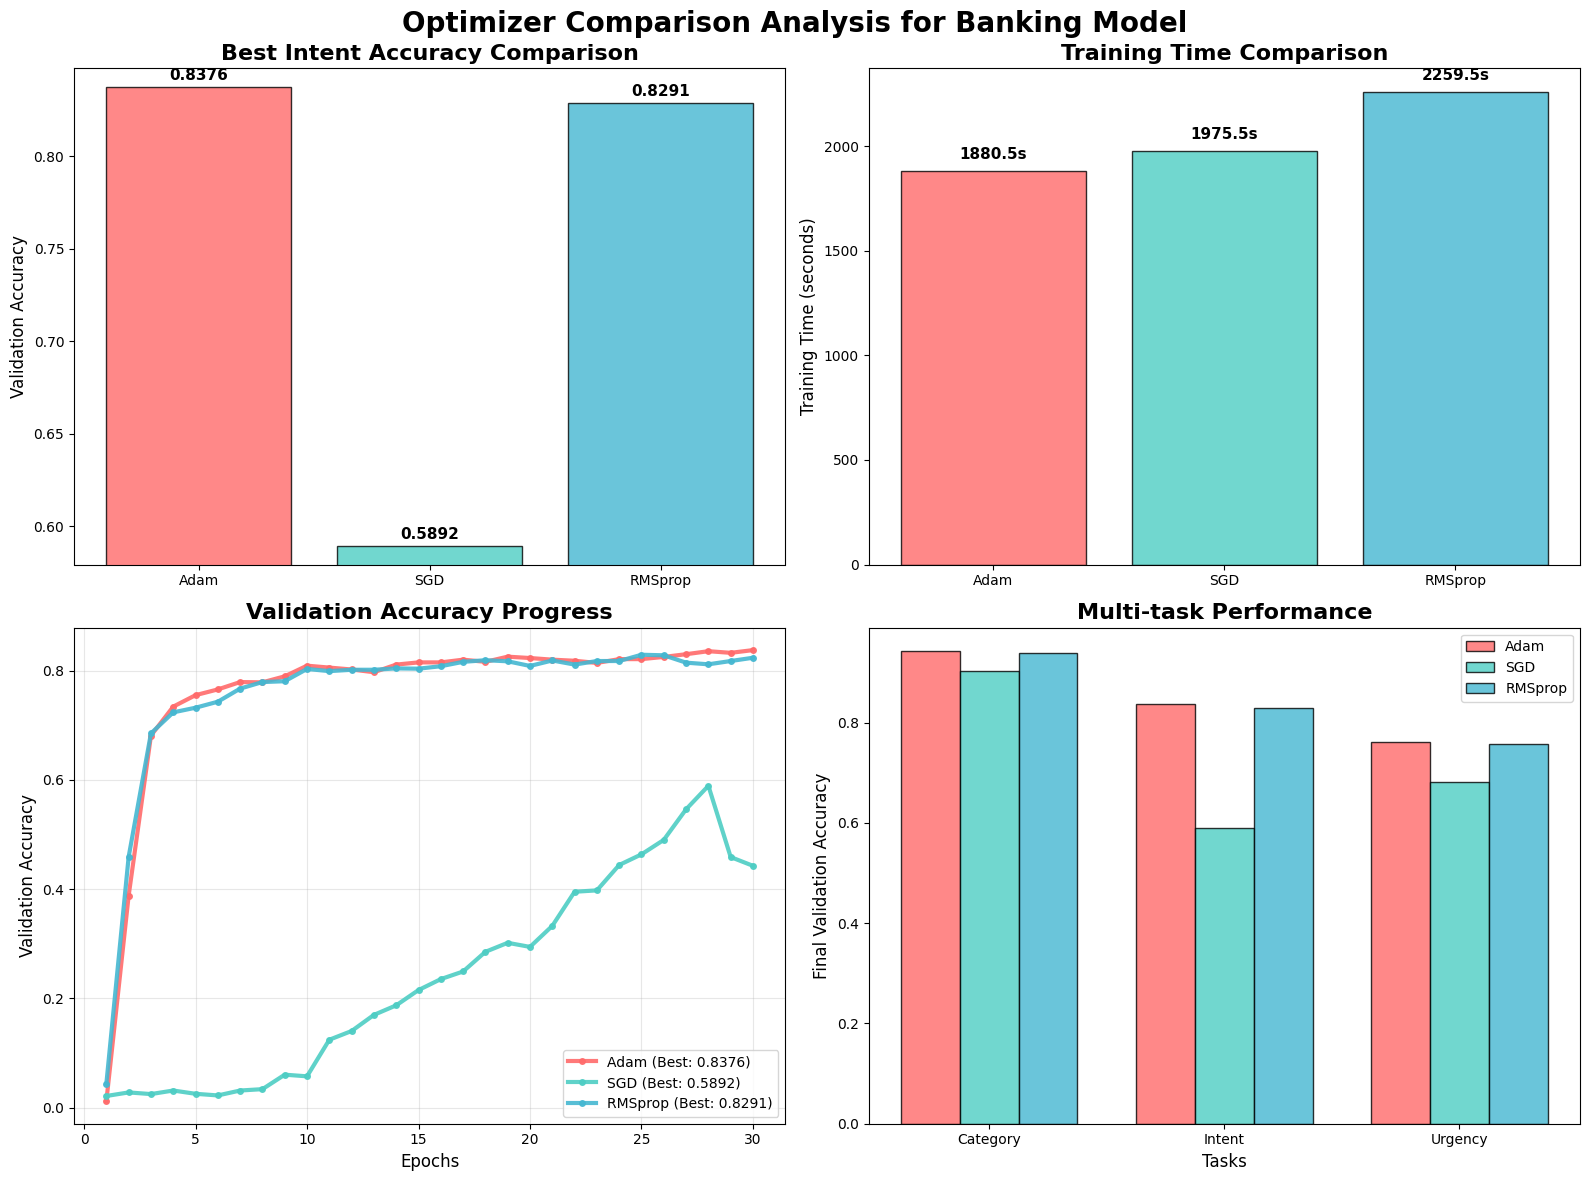

✅ Charts saved as: optimizer_comparison_charts.png


In [ ]:

# CREATE VISUALIZATION


print("\n📊 Creating comparison charts...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Colors for each optimizer
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Red, Teal, Blue

# 1. Best Accuracy Comparison
optimizers = list(optimizer_results.keys())
best_accuracies = [optimizer_results[opt]['best_intent_accuracy'] for opt in optimizers]

bars1 = ax1.bar(optimizers, best_accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Best Intent Accuracy Comparison', fontsize=16, fontweight='bold')
ax1.set_ylabel('Validation Accuracy', fontsize=12)
ax1.set_ylim(min(best_accuracies) - 0.01, max(best_accuracies) + 0.01)

# Add value labels on bars
for bar, acc in zip(bars1, best_accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. Training Time Comparison
training_times = [optimizer_results[opt]['training_time'] for opt in optimizers]

bars2 = ax2.bar(optimizers, training_times, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_title('Training Time Comparison', fontsize=16, fontweight='bold')
ax2.set_ylabel('Training Time (seconds)', fontsize=12)

for bar, time in zip(bars2, training_times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.02,
            f'{time:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 3. Training Progress
for i, optimizer_name in enumerate(optimizers):
    history = optimizer_results[optimizer_name]['history']
    epochs = range(1, len(history['val_intent_output_accuracy']) + 1)
    ax3.plot(epochs, history['val_intent_output_accuracy'],
            label=f"{optimizer_name} (Best: {optimizer_results[optimizer_name]['best_intent_accuracy']:.4f})",
            color=colors[i], linewidth=3, marker='o', markersize=4, alpha=0.9)

ax3.set_title('Validation Accuracy Progress', fontsize=16, fontweight='bold')
ax3.set_xlabel('Epochs', fontsize=12)
ax3.set_ylabel('Validation Accuracy', fontsize=12)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Multi-task Performance
tasks = ['Category', 'Intent', 'Urgency']
x = range(len(tasks))
width = 0.25

for i, optimizer_name in enumerate(optimizers):
    result = optimizer_results[optimizer_name]
    scores = [
        result['final_category_accuracy'],
        result['final_intent_accuracy'],
        result['final_urgency_accuracy']
    ]
    ax4.bar([pos + i*width for pos in x], scores, width,
           label=optimizer_name, color=colors[i], alpha=0.8, edgecolor='black', linewidth=1)

ax4.set_xlabel('Tasks', fontsize=12)
ax4.set_ylabel('Final Validation Accuracy', fontsize=12)
ax4.set_title('Multi-task Performance', fontsize=16, fontweight='bold')
ax4.set_xticks([pos + width for pos in x])
ax4.set_xticklabels(tasks)
ax4.legend(fontsize=10)

plt.suptitle('Optimizer Comparison Analysis for Banking Model', fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('optimizer_comparison_charts.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Charts saved as: optimizer_comparison_charts.png")
